In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

%matplotlib inline
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20, 9)})
sns.set_context("poster", font_scale = 0.6)

In [2]:
connection = sqlite3.connect("./bobby.cool00763_final.db")
cursor = connection.cursor()

In [6]:
get_data_latih = '''
    SELECT l.scraping_id, t.cleantweet, l.last_get, s.sentiment FROM 
    Tweet t INNER JOIN Lastscraping l
    ON t.scraping_id = l.scraping_id
    INNER JOIN Sentiment s
    ON t.tweetid = s.tweetid
    GROUP BY t.cleantweet
'''

data_latih = pd.read_sql(con=connection, sql=get_data_latih, parse_dates=True)
data_latih['last_get'] = pd.to_datetime(data_latih['last_get'], format='%Y-%m-%d %H:%M:%S')
data_latih

,scraping_id,cleantweet,last_get,sentiment
0,58,08 15 gmt k european market open mixed amid co...,2020-11-27 16:01:14,-1
1,15,1 doctor create autoimmune disease use animal ...,2020-11-20 14:03:04,-1
2,15,1 keep gathering small 2 eat outside 3 stay di...,2020-11-20 14:03:04,1
3,9,1 million chinese inject sinopharm vaccine eme...,2020-11-19 21:09:57,-1
4,72,10 try plaster union jack oxford university va...,2020-11-27 19:36:37,0
...,...,...,...,...
3437,17,zacks participate investor roundtable bobbykkr...,2020-11-20 23:07:50,1
3438,46,zaidzamanhamid dr judy mikovitz corruption fed...,2020-11-27 12:57:42,-1
3439,26,ドル円 usdjpy jpy yellen vaccine boj 日本銀行 pfizer ...,2020-11-24 11:18:36,1
3440,21,𝗺 𝗥𝗡𝗔 term come talk covid vaccine mrna molecu...,2020-11-23 10:09:41,1


## TF-iDF

In [51]:
clean_tweet = data_latih['cleantweet'].copy().values.flatten()

vectorizer = TfidfVectorizer(max_features=100)
tf_idf = vectorizer.fit_transform(clean_tweet)

In [52]:
vectorizer.get_feature_names()

['19',
 '2020',
 '2021',
 'astrazeneca',
 'available',
 'biontech',
 'case',
 'china',
 'come',
 'company',
 'corona',
 'coronavaccine',
 'coronavirus',
 'could',
 'country',
 'covid',
 'covid19',
 'covid_19',
 'covidvaccine',
 'covidー19',
 'data',
 'day',
 'development',
 'distribution',
 'dos',
 'dose',
 'effective',
 'efficacy',
 'emergency',
 'end',
 'even',
 'find',
 'first',
 'get',
 'give',
 'global',
 'go',
 'good',
 'government',
 'health',
 'high',
 'hope',
 'india',
 'investment',
 'know',
 'like',
 'lockdown',
 'make',
 'market',
 'mask',
 'may',
 'million',
 'moderna',
 'month',
 'need',
 'new',
 'news',
 'one',
 'oxford',
 'pandemic',
 'people',
 'pfizer',
 'plan',
 'public',
 'question',
 'read',
 'report',
 'result',
 'safe',
 'say',
 'see',
 'share',
 'shot',
 'show',
 'soon',
 'start',
 'stock',
 'stockmarket',
 'take',
 'test',
 'think',
 'time',
 'today',
 'trial',
 'trump',
 'uk',
 'update',
 'use',
 'vaccinate',
 'vaccination',
 'vaccine',
 'via',
 'virus',
 'want

## NMF Topic Modelling

In [57]:
nmf_decompose = NMF(n_components=3, init='nndsvd')
W = nmf_decompose.fit_transform(tf_idf)
H = nmf_decompose.components_
print(W.shape, H.shape)

(3442, 3) (3, 100)


In [58]:
topics = []
for index, topic in enumerate(H):
    feature_names = vectorizer.get_feature_names()
    topics.append(' '.join([feature_names[i] for i in topic.argsort()[-5:]]))

topics

['distribution need take get vaccine',
 'astrazeneca stockmarket pfizer 19 covid',
 'get say coronavaccine coronavirus covid19']

In [59]:
tweet_topics = []

for tweet in clean_tweet:
    tweet_to_vector = vectorizer.transform([tweet])
    prob_score = nmf_decompose.transform(tweet_to_vector)

    tweet_topics.append(topics[np.argmax(prob_score)])

data_latih['topic'] = tweet_topics
data_latih

,scraping_id,cleantweet,last_get,sentiment,topic
0,58,08 15 gmt k european market open mixed amid co...,2020-11-27 16:01:14,-1,distribution need take get vaccine
1,15,1 doctor create autoimmune disease use animal ...,2020-11-20 14:03:04,-1,distribution need take get vaccine
2,15,1 keep gathering small 2 eat outside 3 stay di...,2020-11-20 14:03:04,1,get say coronavaccine coronavirus covid19
3,9,1 million chinese inject sinopharm vaccine eme...,2020-11-19 21:09:57,-1,distribution need take get vaccine
4,72,10 try plaster union jack oxford university va...,2020-11-27 19:36:37,0,distribution need take get vaccine
...,...,...,...,...,...
3437,17,zacks participate investor roundtable bobbykkr...,2020-11-20 23:07:50,1,astrazeneca stockmarket pfizer 19 covid
3438,46,zaidzamanhamid dr judy mikovitz corruption fed...,2020-11-27 12:57:42,-1,distribution need take get vaccine
3439,26,ドル円 usdjpy jpy yellen vaccine boj 日本銀行 pfizer ...,2020-11-24 11:18:36,1,get say coronavaccine coronavirus covid19
3440,21,𝗺 𝗥𝗡𝗔 term come talk covid vaccine mrna molecu...,2020-11-23 10:09:41,1,distribution need take get vaccine


## Analisis Tren (Jumat, 27 November 2020, 12:00-20:59)

In [60]:
data_27nov = data_latih[data_latih['scraping_id'] >= 43]
data_27nov[:]['last_get'] = pd.to_datetime(data_27nov['last_get'])
data_27nov[:]['last_get'] = data_27nov['last_get'].dt.strftime('%H:%M')
data_27nov.reset_index(drop=True, inplace=True)

In [61]:
data_27nov

,scraping_id,cleantweet,last_get,sentiment,topic
0,58,08 15 gmt k european market open mixed amid co...,2020-11-27 16:01:14,-1,distribution need take get vaccine
1,72,10 try plaster union jack oxford university va...,2020-11-27 19:36:37,0,distribution need take get vaccine
2,52,100 million dos russian covid 19 vaccine sputn...,2020-11-27 14:29:32,0,astrazeneca stockmarket pfizer 19 covid
3,61,12 8 million dos covid 19 vaccine secure pfize...,2020-11-27 16:46:57,1,astrazeneca stockmarket pfizer 19 covid
4,60,127 death measles vaccine last 15 year prof me...,2020-11-27 16:31:39,-1,distribution need take get vaccine
...,...,...,...,...,...
685,60,xrp decouple bitcoin price one long dream besi...,2020-11-27 16:31:39,1,get say coronavaccine coronavirus covid19
686,44,yes time infinity covidー19 vaccine,2020-11-27 12:27:12,1,distribution need take get vaccine
687,74,young advocate vision world w new hiv infectio...,2020-11-27 20:07:26,1,distribution need take get vaccine
688,46,zaidzamanhamid dr judy mikovitz corruption fed...,2020-11-27 12:57:42,-1,distribution need take get vaccine


In [93]:
data_27nov.groupby(['topic', 'sentiment'])['topic'].count()
# data_27nov.groupby(['sentiment', 'topic'])['topic'].count()

topic                                      sentiment
astrazeneca stockmarket pfizer 19 covid    -1            47
                                            0            51
                                            1            55
distribution need take get vaccine         -1            59
                                            0            63
                                            1           108
get say coronavaccine coronavirus covid19  -1            68
                                            0            86
                                            1           153
Name: topic, dtype: int64

## Analisis Tren Topik

In [79]:
trend_per_topic = data_27nov.groupby(['topic']).resample('H', on='last_get')['topic'].count()

i = 0
trend_data = []
for index in list(trend_per_topic.index):
    hour_range = f'{index[1].hour}:00 - {index[1].hour}:59'
    trend_data.append([index[0], hour_range, trend_per_topic[i]])
    i += 1

trend_df = pd.DataFrame(data=trend_data, columns=['Topic', 'Time', 'N_topic'])
trend_df
# trend_per_topic.index

,Topic,Time,N_topic
0,astrazeneca stockmarket pfizer 19 covid,12:00 - 12:59,10
1,astrazeneca stockmarket pfizer 19 covid,13:00 - 13:59,16
2,astrazeneca stockmarket pfizer 19 covid,14:00 - 14:59,19
3,astrazeneca stockmarket pfizer 19 covid,15:00 - 15:59,18
4,astrazeneca stockmarket pfizer 19 covid,16:00 - 16:59,21
5,astrazeneca stockmarket pfizer 19 covid,17:00 - 17:59,15
6,astrazeneca stockmarket pfizer 19 covid,18:00 - 18:59,18
7,astrazeneca stockmarket pfizer 19 covid,19:00 - 19:59,13
8,astrazeneca stockmarket pfizer 19 covid,20:00 - 20:59,23
9,distribution need take get vaccine,12:00 - 12:59,17


<AxesSubplot:xlabel='Time', ylabel='N_topic'>

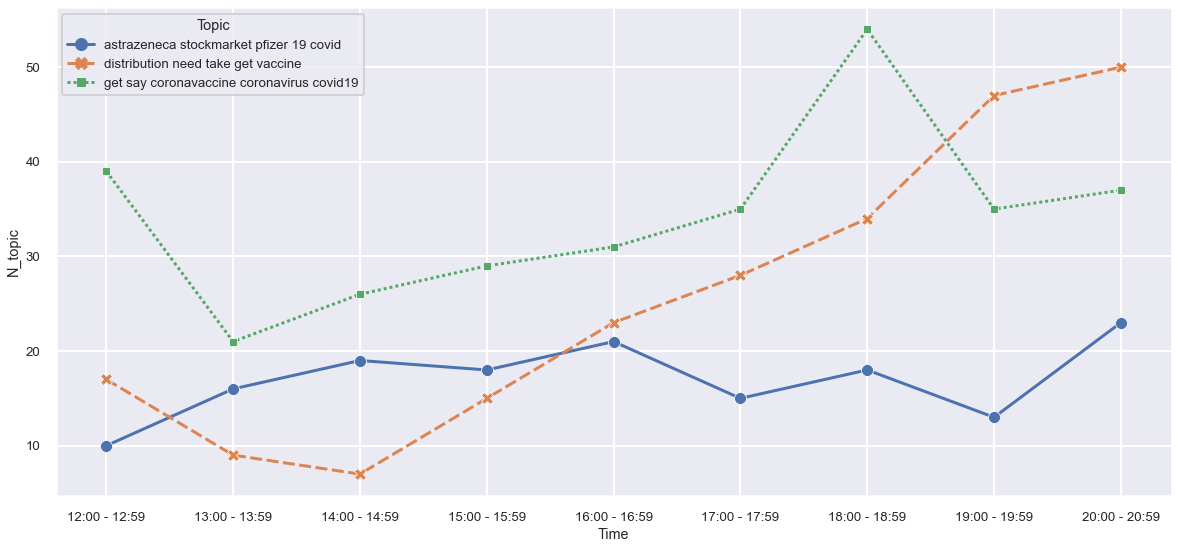

In [80]:
sns.lineplot(data=trend_df, x='Time', y='N_topic', hue='Topic', markers=True, style='Topic')

## Analisis Tren Sentimen

In [109]:
trend_per_sentiment = data_27nov.groupby(['sentiment']).resample('H', on='last_get')['topic'].count()
trend_per_sentiment.index
i = 0
trend_data = []
for index in list(trend_per_sentiment.index):
    hour_range = f'{index[1].hour}:00 - {index[1].hour}:59'
    sentiment = "Positive" if index[0] == 1 else ("Neutral" if index[0] == 0 else "Negative")
    trend_data.append([sentiment, hour_range, trend_per_sentiment[index[0]][i%9]])
    i += 1
sentiment_df = pd.DataFrame(data=trend_data, columns=['Sentiment', 'Time', 'N_sentiment'])
sentiment_df

,Sentiment,Time,N_sentiment
0,Negative,12:00 - 12:59,25
1,Negative,13:00 - 13:59,10
2,Negative,14:00 - 14:59,11
3,Negative,15:00 - 15:59,18
4,Negative,16:00 - 16:59,25
5,Negative,17:00 - 17:59,10
6,Negative,18:00 - 18:59,28
7,Negative,19:00 - 19:59,17
8,Negative,20:00 - 20:59,30
9,Neutral,12:00 - 12:59,12


<AxesSubplot:xlabel='Time', ylabel='N_sentiment'>

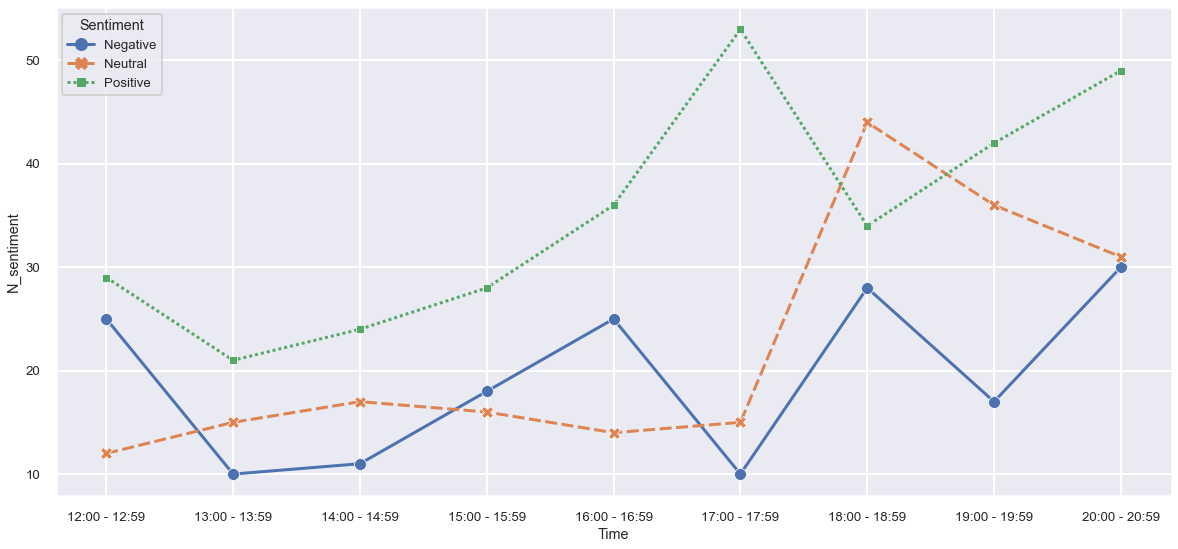

In [110]:
sns.lineplot(data=sentiment_df, x='Time', y='N_sentiment', hue='Sentiment', markers=True, style='Sentiment')